<a href="https://colab.research.google.com/github/xbadiam/Portfolio/blob/main/Preventive_Maintenance/Nasa_Turbofan_Engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## NASA Turbofan Engine

## Mantenimiento Predictivo en la Industria 4.0: Anticipación de Fallos y Optimización de Maquinaria mediante Machine Learning.

## 1. Introducción

El objetivo de este conjunto de datos es predecir la vida útil remanente (RUL, por sus siglas en inglés) de cada motor en el conjunto de prueba. La RUL equivale al número de vuelos restantes para el motor después del último punto de datos en el conjunto de prueba.






In [49]:
! git clone https://github.com/xbadiam/Portfolio.git

fatal: destination path 'Portfolio' already exists and is not an empty directory.


## 2. Imports

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tabulate import tabulate

from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error, mean_absolute_error


## 3. Funciones especiales

In [51]:
def evaluate(y, pred, label='test'):
    mae = mean_absolute_error(y, pred)
    rmse = np.sqrt(mean_squared_error(y, pred))
    r2 = r2_score(y, pred)
    print(f'----- {label} -----\nRMSE: {round(rmse, 2)}\nMAE : {round(mae, 2)}\nR2  : {round(r2, 2)}\n')
    return mae, rmse, r2


def plot_result_evaluate(y_test, preds_test):
    plt.scatter(y_test, preds_test, color="blue")

    # Agregar la línea de referencia (abline)
    min_val = min(min(y_test), min(preds_test))
    max_val = max(max(y_test), max(preds_test))
    plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Línea ideal (y=x)")

    plt.xlabel("Valores reales")
    plt.ylabel("Predicciones")
    plt.title("Valores reales vs Predicciones")

    plt.show()


def plot_serie_evaluate_result(y_test,preds_test):
    # Plot Actual Vs Predicted RUL for Test Data
    fig = plt.figure();
    plt.figure(figsize=[20,5])
    plt.plot(y_test,color="blue", linewidth=2.5, linestyle="-",label="Actual")
    plt.plot(preds_test,color="red",  linewidth=2.5, linestyle="-",label="Predicted")
    fig.suptitle('Actual and Predicted', fontsize=20)
    plt.xlabel('Motor')
    plt.ylabel('RUL', fontsize=16)
    plt.legend()
    plt.title("RUL real vs. RUL previsto para datos de test")

## 4. Carga de los datos



In [52]:
# Cargar los datos de entrenamiento
train_data = pd.read_csv("/content/Portfolio/Preventive_Maintenance/train_FD001.txt", sep=' ', header=None)

# Cargar los datos de prueba
test_data = pd.read_csv("/content/Portfolio/Preventive_Maintenance/test_FD001.txt", sep=' ', header=None)

# Cargar la vida útil restante verdadera
truth_data = pd.read_csv("/content/Portfolio/Preventive_Maintenance/RUL_FD001.txt", header=None)


### 4.1. Conjunto de datos

A continuación, se asigna los nombres a las columnas de los tres ficheros. Para ello, se consulta los nombres de las variables facilitados en el entorno web de NASA's Open Data Portal. Cada fila es un instante de los datos tomados durante un único ciclo operativo y cada columna es una variable diferente.

* unit_number: identificador de la unidad (motor)
* time_cycles: time, in cycles
* op_set1: configuración operativa 1
* op_set2: configuración operativa 2
* op_set3: configuración operativa 3
* s_1: medición del sensor 1
* s_2: medición del sensor 1
.......
* s_26 medición del sensor 26

Se cargan tres ficheros de tipo CSVcon los datos de entrenamiento formado por las lecturas de sensores a lo largo d e ciclos operativos completos. Con el fin de dar mejor claridad al alto número de variables en la exploración de los datos, se definen dos variables que permiten separar las variables en dos grupos: datos del motor y los sensores.

In [53]:
#Eliminanos las dos últimas columnas, ya que solo presentan valores NaN
train_data = train_data[train_data.columns[:-2]]
test_data = test_data[test_data.columns[:-2]]

In [54]:
# Define los nombres configuración de los motores y de los sensores separados
unit_settings_names = ['unit_number', 'time_cycles','op_set1', 'op_set2', 'op_set3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)]

# Conjunto de los nombres de las variables
column_names = unit_settings_names + sensor_names

train_data.columns = column_names
test_data.columns = column_names
truth_data.columns = ["RUL"]


**Dataframe del conjunto de datos de entrenamiento**

In [55]:
train_data.head()

,unit_number,time_cycles,op_set1,op_set2,op_set3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


Cada fila representa una serie de datos tomados durante un ciclo operativo único, y cada columna representa una variable diferente.

**Dataframe del conjunto de datos de test**

In [56]:
test_data.head()

,unit_number,time_cycles,op_set1,op_set2,op_set3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


**Dataframe del conjunto de datos truth_data**

In [57]:
truth_data.head()

,RUL
0,112
1,98
2,69
3,82
4,91


## 5. Exploración de los datos

### 5.1. Resumen de los datos


In [58]:
# Dimensión de los datos
print("Dimensiones de los datos de entrenamiento:", train_data.shape)
print("Dimensiones de los datos de prueba:", test_data.shape)
print("Dimensiones de los datos de RUL:", truth_data.shape)

Dimensiones de los datos de entrenamiento: (20631, 26)
Dimensiones de los datos de prueba: (13096, 26)
Dimensiones de los datos de RUL: (100, 1)


In [59]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_number  20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   op_set1      20631 non-null  float64
 3   op_set2      20631 non-null  float64
 4   op_set3      20631 non-null  float64
 5   s_1          20631 non-null  float64
 6   s_2          20631 non-null  float64
 7   s_3          20631 non-null  float64
 8   s_4          20631 non-null  float64
 9   s_5          20631 non-null  float64
 10  s_6          20631 non-null  float64
 11  s_7          20631 non-null  float64
 12  s_8          20631 non-null  float64
 13  s_9          20631 non-null  float64
 14  s_10         20631 non-null  float64
 15  s_11         20631 non-null  float64
 16  s_12         20631 non-null  float64
 17  s_13         20631 non-null  float64
 18  s_14         20631 non-null  float64
 19  s_15

In [60]:
truth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   RUL     100 non-null    int64
dtypes: int64(1)
memory usage: 932.0 bytes


In [61]:
# Valores únicos variable unit_number
train_data['unit_number'].unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

En este caso, es una secuencia de números enteros del 1 al 100. Son 100 unidades distintas en el conjunto de datos de entrenamiento.

## 6. Análisis estadístico de los datos

## 6.1. Estadística descriptiva.¶

La función describe() obtiene las estadísticas descriptivas donde se presenta la tendencia central, la dispersión y la forma de distribución del conjunto de datos. Con el fin de facilitar la visualización de los datos estadísticos, se ha separado en dos tablas.

In [62]:
# Valores estadísticos los motores.
train_data[unit_settings_names].describe()

,unit_number,time_cycles,op_set1,op_set2,op_set3
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0
std,29.227633,68.880990,0.002187,0.000293,0.0
min,1.000000,1.000000,-0.008700,-0.000600,100.0
25%,26.000000,52.000000,-0.001500,-0.000200,100.0
50%,52.000000,104.000000,0.000000,0.000000,100.0
75%,77.000000,156.000000,0.001500,0.000300,100.0
max,100.000000,362.000000,0.008700,0.000600,100.0


El rango de los ciclos (time cycles) varía entre 1 y 362, lo cual sugiere que algunos motores tienen un ciclo de vida más corto que otros. La distribución de las variables operativas op_set1 y op_set2 los valores promedio están cerca de cero, presentan cierta variabilidad, lo cual indica cambios en las condiciones de operación. La variable op_set3 presenta valores constantes (100.0) y su desviación estándard es 0. Estas variables se pueden eliminar del conjunto de datos de entrenamiento y test, ya que no contribuyen a la predicción.

In [63]:
# Valores estadísticos de los sensores
train_data[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,6.537152e-11,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,3.394700e-12,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,4.660829e-13,1.3000,1.3000,1.3000,1.3000,1.3000


Las variables op_set3, s_1, s_5, s_6, s_10, s_16, s_18 y s_19 presentan valores constantes en sus estadísticas descriptivas. Estas variables se eliminan del conjunto de datos de entrenamiento y de test.

In [64]:
# Lista de columnas constantes identificadas
constant_sensors = ['op_set3','s_1','s_5','s_6','s_10','s_16','s_18','s_19']

# Eliminar columnas constantes del dataset
train_data = train_data.drop(columns=constant_sensors)

train_data.head()

,unit_number,time_cycles,op_set1,op_set2,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,s_15,s_17,s_20,s_21
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


### 6.2. Distribución de la variable Objetivo

En este análisis, la variable objetivo es el Remaining Useful Life (RUL). El RUL actúa como la etiqueta (objetivo) que se quiere predecir, por lo que debe estar presente en el conjunto de entrenamiento para entrenar los modelos supervisados.

El RUL se calcula a partir de la diferencia entre el ciclo de vida máximo alcanzado por el motor y el ciclo actual de operación.

$$ RUL = \text{Ciclo de vida máximo del motor} - \text{Ciclo actual}$$

Los valores para realizar el cálculo se pueden obtener del mismo dataset de entrenamiento. El ciclo de vida máximo de cada motor puede calcularse agrupando sus diferentes ciclos y obteniendo el ciclo máximo. El ciclo actual se obtiene accediendo al valor de la variable time_cycle.


In [65]:
# Se agrupan los datos por número de unidad (motor)
grouped_by_unit = train_data.groupby(by="unit_number")

# Se obtiene el valor máximo de time_cycles para cada motor.
max_cycle = grouped_by_unit["time_cycles"].max()

# Se agrega en un dataframe la información del ciclo máximo correspondiente a cada motor.
merge_max_cycle = train_data.merge(max_cycle.to_frame(name='max_cycle'), right_index=True, left_on='unit_number')

# se calcula el RUL como la diferencia entre el ciclo máximo y el ciclo actual
rul = merge_max_cycle["max_cycle"] - merge_max_cycle["time_cycles"]

merge_max_cycle["RUL"] = rul

# se elimina max_cycle ya que es necesario
merge_max_cycle = merge_max_cycle.drop("max_cycle", axis=1)

train_data = merge_max_cycle

In [66]:
train_data[['unit_number', 'time_cycles', 'op_set1', 'op_set2','RUL']].head()

,unit_number,time_cycles,op_set1,op_set2,RUL
0,1,1,-0.0007,-0.0004,191
1,1,2,0.0019,-0.0003,190
2,1,3,-0.0043,0.0003,189
3,1,4,0.0007,0.0000,188
4,1,5,-0.0019,-0.0002,187


**Hisntograma de distrubición de RUL**

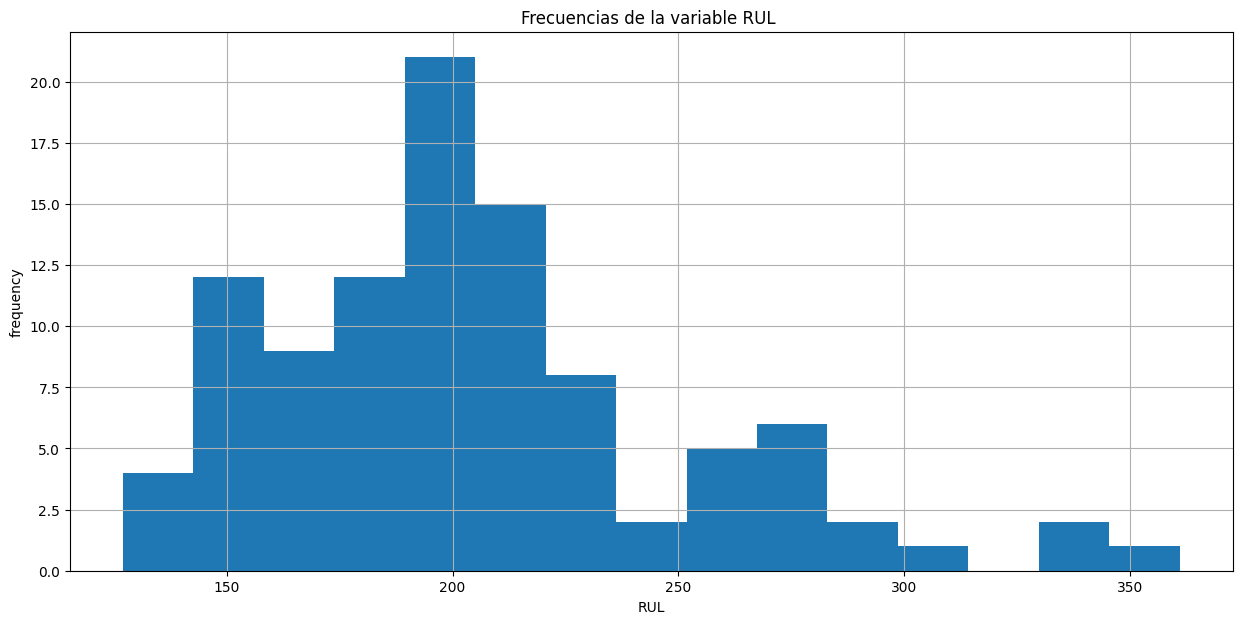

In [67]:
# Distribución de RUL
df_max_rul = train_data[['unit_number', 'RUL']].groupby('unit_number').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.title("Frecuencias de la variable RUL ")
plt.show()

El histograma muestra la distribución de la cantidad de ciclos operativos hasta la falla de los motores de turbina. La variable en el eje horizontal representa el número de ciclos, mientras que la frecuencia de cada rango de ciclos se muestra en el eje vertical.

La mayoría de los motores fallan entre 150 y 220 ciclos operativos, tal como se visualiza la concentración más alta de la frecuencia en ese rango. Hay menos motores que alcanzan ciclos operativos superiores a 250 antes de fallar, lo que sugiere que pocos motores tienen una vida útil tan extendida. Esta gráfica es útil el comportamiento de desgaste de los motores, lo cual es relevante para la predicción de la vida útil restante (RUL).

### 6.3. Distribución de las variables predictorias

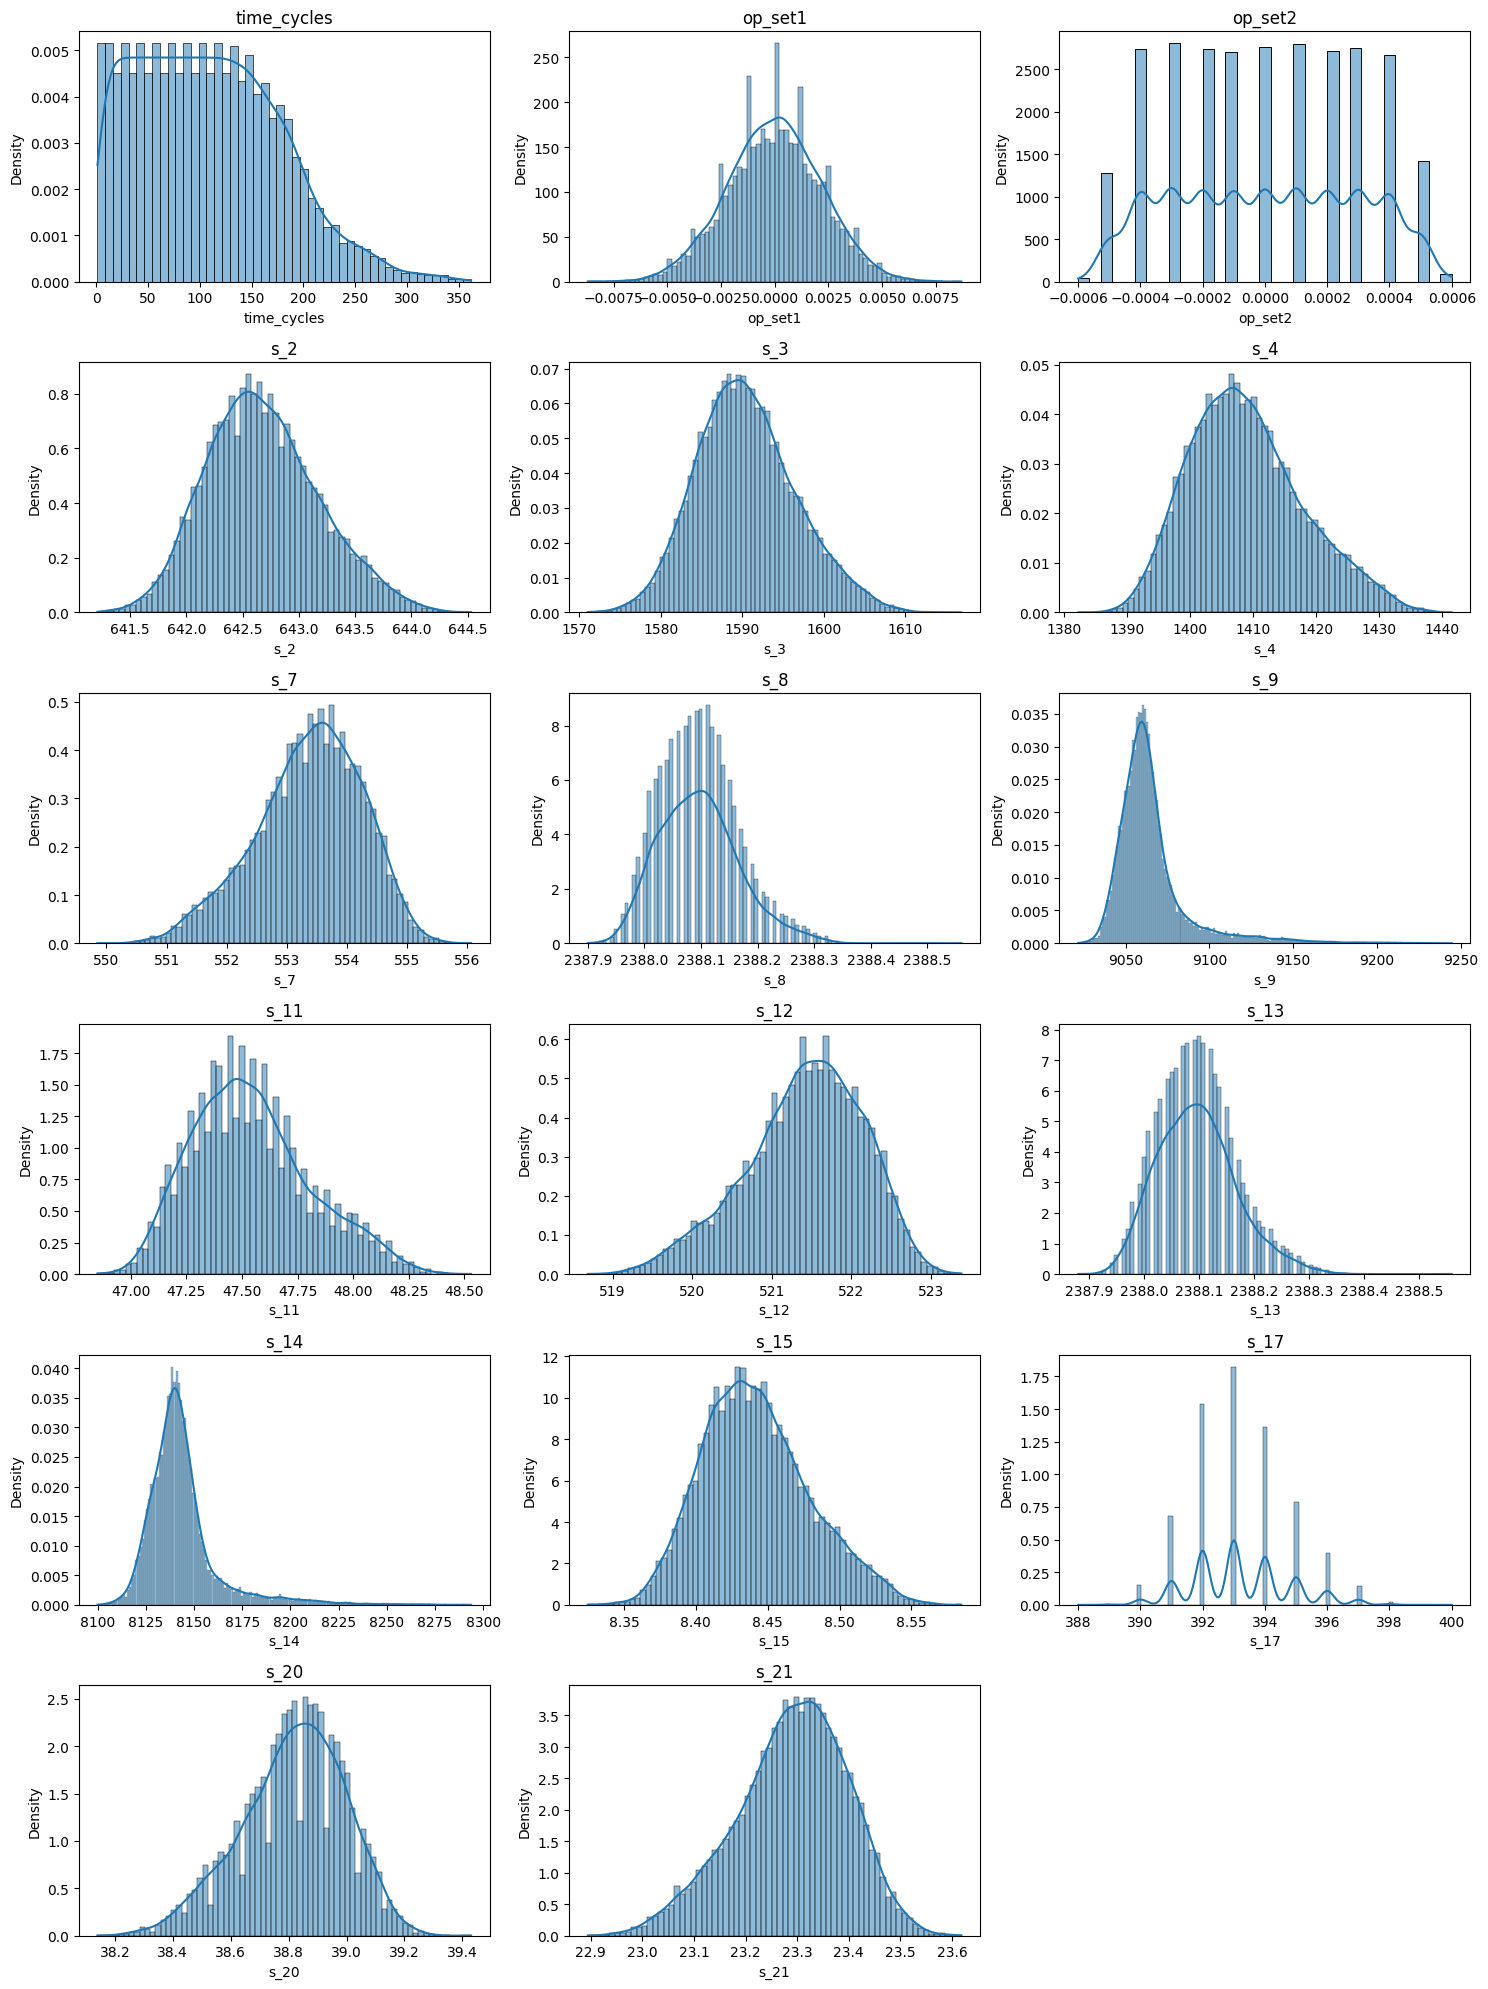

In [68]:
# Seleccionamos las 12 variables predictorias
nrows, ncols = 6, 3
cols = train_data.iloc[:,1:18]

# Crea la figura y los ejes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,20))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes[:len(cols.columns)]):
    sns.histplot(data=train_data[col], kde=True, stat='density', ax=ax)
    ax.set_title(col)

# Oculta ejes sobrantes si hay más subgráficos que columnas
for ax in axes[len(cols.columns):]:
    ax.set_visible(False)

# Se ajusta las gráficas
plt.tight_layout()
plt.show()

Las distribuciones normales pueden ser indicativas de datos estables o controlados, mientras que una distribución sesgada (asimétrica) o con múltiples picos puede sugerir la presencia de diferentes modos de operación del motor o cambios en las condiciones.

## 6.4. Valores atípicos

En esta sección se Identifican los valores atípicos, es decir, aquellos valores que se encuentran fuera del rango esperado en cada sensor. Estos valores atípicos pueden ser relevantes para detectar posibles anomalías o fallas en los motoreses.

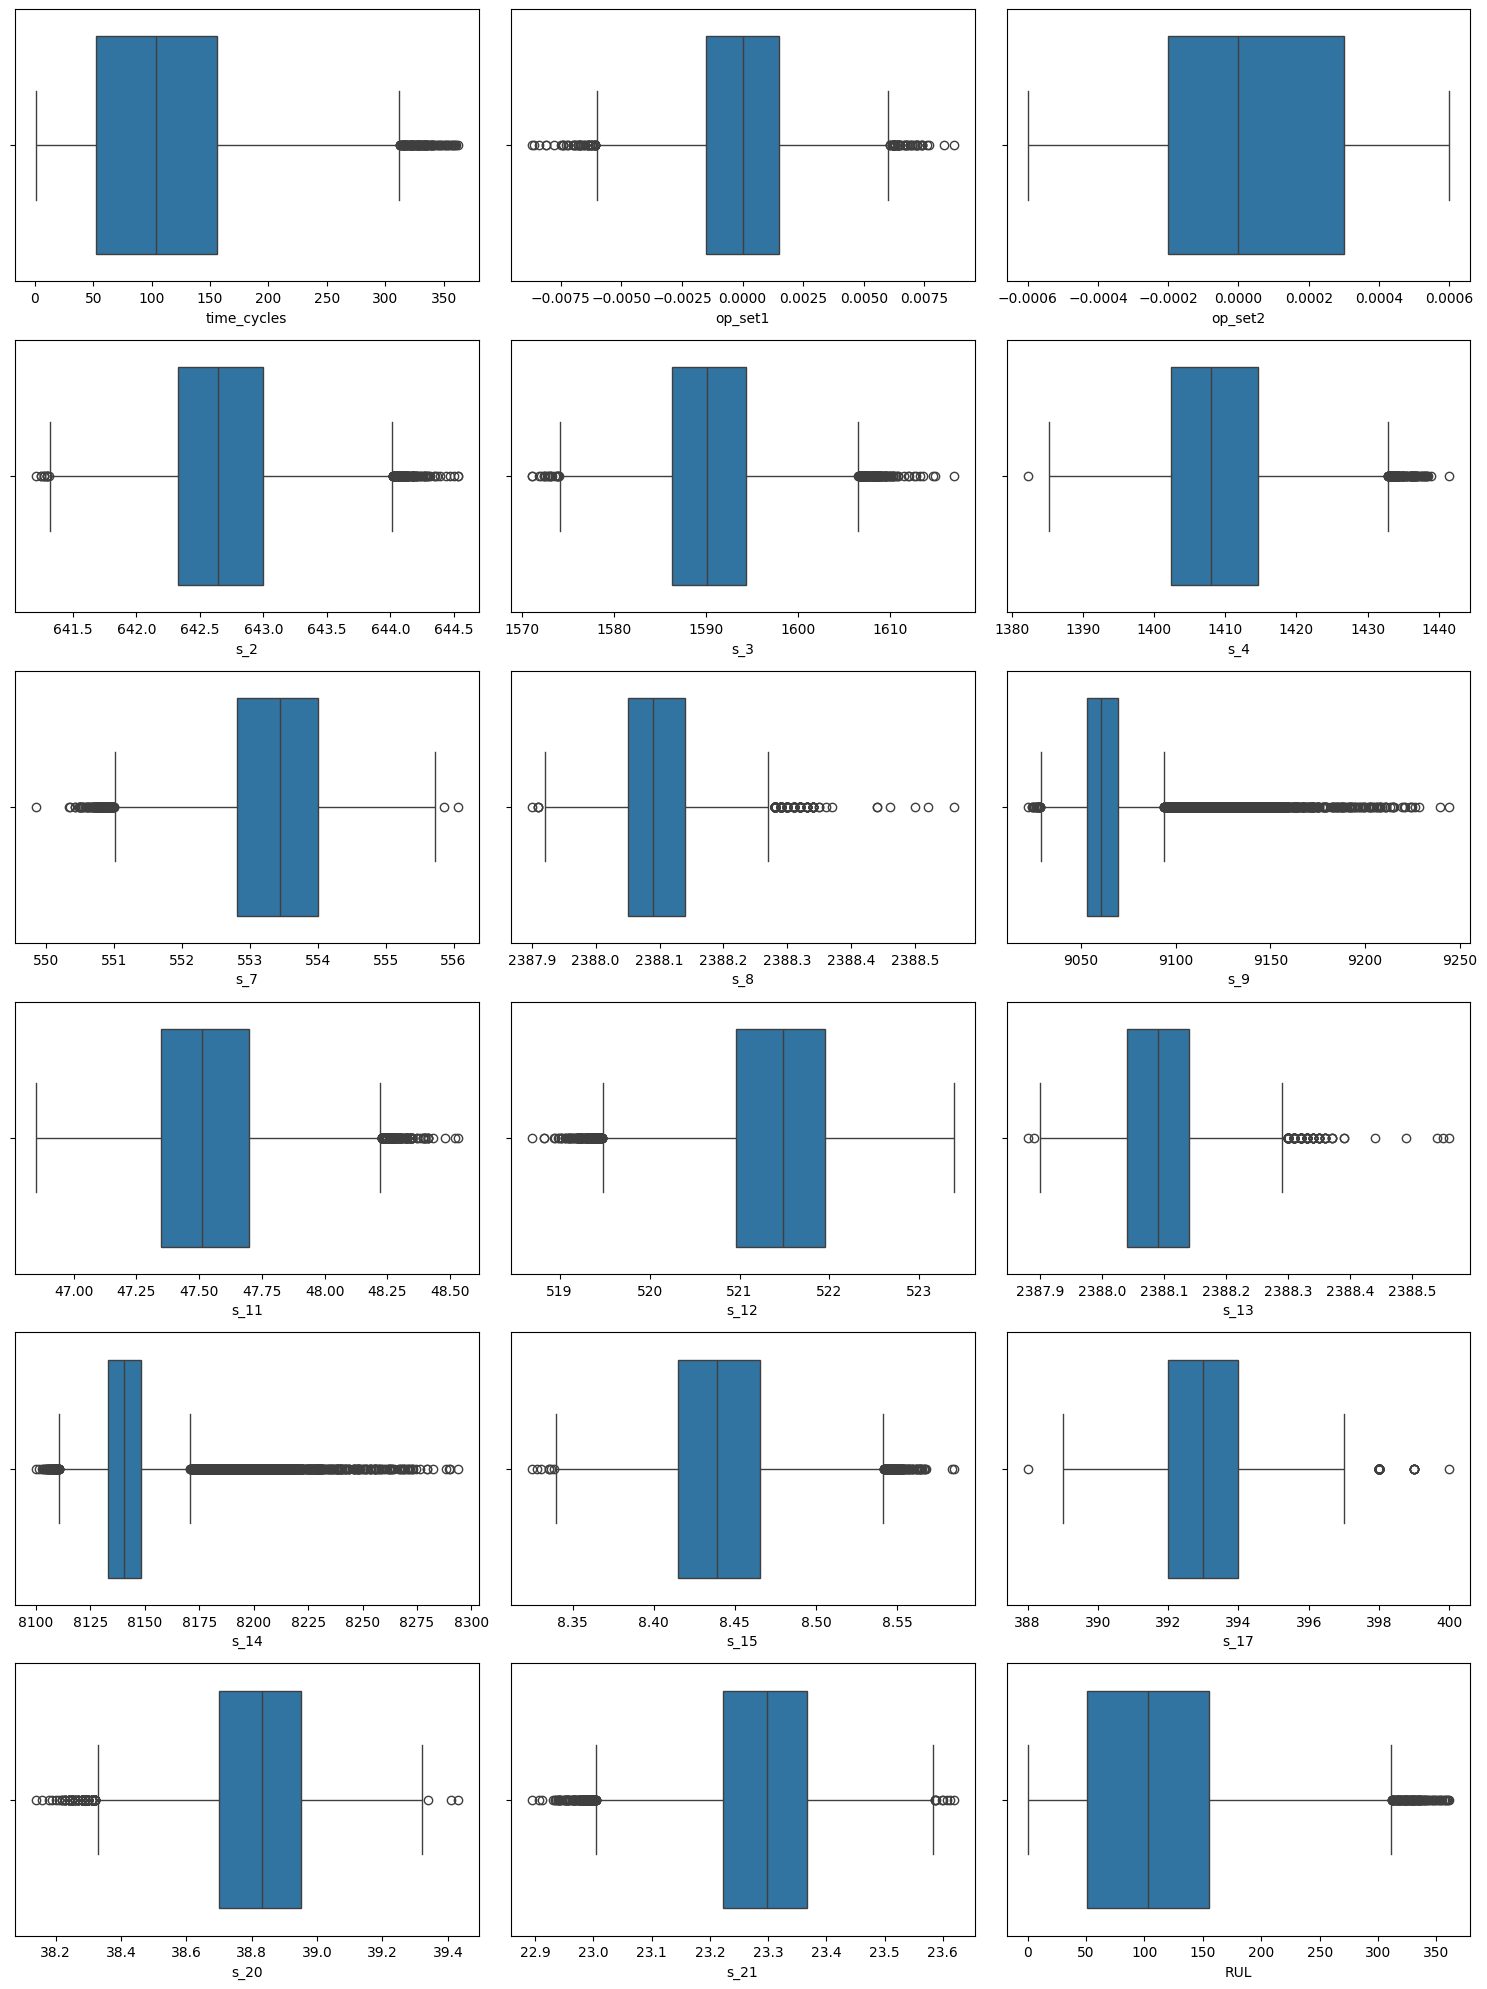

In [69]:
# Seleccionamos las variables
nrows, ncols = 6, 3
cols = train_data.iloc[:,1:19]

# Crea la figura y los ejes
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,20))
axes = axes.ravel()  # flattening the array makes indexing easier

for col, ax in zip(cols, axes):
    sns.boxplot(x=train_data[col], ax=ax)

# Ajusta las gráficas
plt.tight_layout()
plt.show()

En la imagen de los diagramas de caja, las variables como time cycles, s_2, y s_3 muestran una cantidad considerable de puntos fuera del rango intercuartílico (IQR).

La mayoría de las variables presentan una dispersión centralizada con bigotes de longitud moderada, lo que indica que gran parte de los datos se concentran cerca de los valores mediana y cuartiles.

Gran parte de las variables, presentan una cantidad considerable de puntos que corresponden a valores atípicos. La variable s_9 tiene una concentración significativa de valores atípicos en el extremo superior, lo que podría indicar comportamientos anómalos. s_7, s_8, s_11, s_12 y s_13 también presentan valores atípicos, aunque en menor cantidad, distribuidos en ambos extremos.

Las variables s_14, s_15 y s_20 presentan valores atípicos en ambos extremos, con una mayor concentración en el extremo superior. La cantidad considerable de valores atípicos en el sensor s_14, podría reflejar anomalías.

Las variables s_17 y s_21 muestran menos valores atípicos en comparación, con una distribución más centrada.

La variable RUL, que mide el tiempo de vida útil restante, presenta una amplia dispersión y valores atípicos en el extremo superior. Esto indica que hay motores que aún tienen una larga vida útil y podrí en modelos predictivos.edictivos.

### 3.5. Correlación entre Variables.

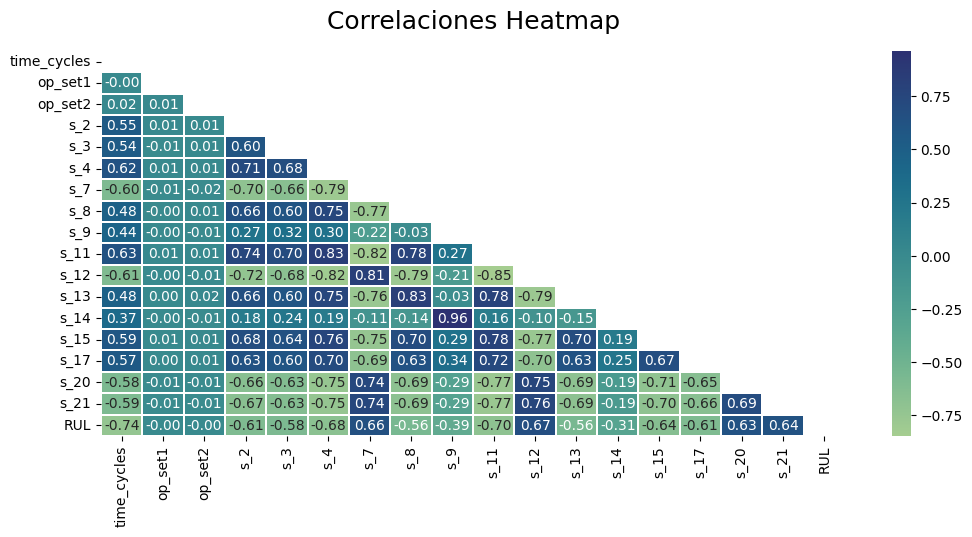

In [70]:
# selección de las columnas específicas
var_cor_max = train_data.iloc[:,1:20]

plt.figure(figsize=(12, 5))

# definición de la máscara para establecer los valores en el triángulo superior
mask = np.triu(np.ones_like(var_cor_max.corr(method='pearson'), dtype=bool))
heatmap = sns.heatmap(var_cor_max.corr(method='pearson'), mask=mask,
                      annot=True , fmt = '0.2f' , cmap='crest' , linewidths=0.01)

heatmap.set_title('Correlaciones Heatmap', fontdict={'fontsize':18}, pad=16);

**Correlación con el RUL**: Algunas variables como s_4, y s_11 muestran una fuerte correlación negativa con el RUL, lo que indica que estas mediciones disminuyen significativamente a medida que el motor se aproxima a su falla.

**Relaciones entre sensores**: Se observa correlaciones muy altas entre sensores como son: s_11 y s_12 (-0.85), s_9 y s_14 (0.96), s_13 y s_8 (0.83), lo que podría indicar redundancia entre estas variables.

Variables de baja correlación: algunas variables, como op_set1 y op_set2, tienen correlaciones muy bajas o cercanas a cero con el RUL, lo que sugiere que podrían no ser tan útiles directamente para la predicción del RUL. Sin embargo, aún podrían ser útiles en combinación con otras variables.

## 7. Análisis de la calidad de los datos

### 7.1. Detención de datos faltantes

In [71]:
# Detección de valores faltantes en los datos de entrenamiento
missing_values = train_data.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)


Valores faltantes por columna:
unit_number    0
time_cycles    0
op_set1        0
op_set2        0
s_2            0
s_3            0
s_4            0
s_7            0
s_8            0
s_9            0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_17           0
s_20           0
s_21           0
RUL            0
dtype: int64


In [72]:
# Detección de valores faltantes en los datos de test
missing_values = test_data.isnull().sum()
print("Valores faltantes por columna:")
print(missing_values)

Valores faltantes por columna:
unit_number    0
time_cycles    0
op_set1        0
op_set2        0
op_set3        0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64


## 7.2. Eliminación de valores que presentan alta correlación

Los sensores con alta correlación (positiva o negativa) con el RUL, son más relevantes para el modelo predictivo. Por ejemplo, s_11, s_12, y s_7. Las Variables con baja correlación con el RUL pueden ser descartadas o utilizadas en transformaciones más complejas (por ejemplo, combinaciones no lineales).

Un primer inicio es seleccionar solo aquellas características que tengan un valor absoluto de correlación con RUL mayor o igual a 0,5.

In [73]:
cor = train_data.corr(method='pearson')

# Selección de características correlacionadas con la variable RUL
train_high_corr = cor[abs(cor['RUL']) >= 0.5]
data =  pd.DataFrame(train_high_corr['RUL'])

# Creación de una tabla con las correlaciones
table = tabulate(
    data,
    headers=["Variable", "Coef. corr"],
    tablefmt = "fancy_grid",
    maxcolwidths=[None, 2]
)

print(table)

╒═════════════╤══════════════╕
│ Variable    │   Coef. corr │
╞═════════════╪══════════════╡
│ time_cycles │    -0.736241 │
├─────────────┼──────────────┤
│ s_2         │    -0.606484 │
├─────────────┼──────────────┤
│ s_3         │    -0.58452  │
├─────────────┼──────────────┤
│ s_4         │    -0.678948 │
├─────────────┼──────────────┤
│ s_7         │     0.657223 │
├─────────────┼──────────────┤
│ s_8         │    -0.563968 │
├─────────────┼──────────────┤
│ s_11        │    -0.696228 │
├─────────────┼──────────────┤
│ s_12        │     0.671983 │
├─────────────┼──────────────┤
│ s_13        │    -0.562569 │
├─────────────┼──────────────┤
│ s_15        │    -0.642667 │
├─────────────┼──────────────┤
│ s_17        │    -0.606154 │
├─────────────┼──────────────┤
│ s_20        │     0.629428 │
├─────────────┼──────────────┤
│ s_21        │     0.635662 │
├─────────────┼──────────────┤
│ RUL         │     1        │
╘═════════════╧══════════════╛


In [74]:
# Se obtiene el índice de la características correlacionadas con la variable RUL
list_relevant_features = data.index

# Se selecciona el nombre de las variables.
list_relevant_features = list_relevant_features[1:]
list_relevant_features

Index(['s_2', 's_3', 's_4', 's_7', 's_8', 's_11', 's_12', 's_13', 's_15',
       's_17', 's_20', 's_21', 'RUL'],
      dtype='object')

Seguidamente, se seleccionan del conjunto de datos de entrenamiento las variables obtenidas en el paso anterior.

In [75]:
train_data = train_data[list_relevant_features]
train_data.head()

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21,RUL
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,191
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,190
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,189
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,188
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,187


Las variables que están altamente correlacionadas con otras pueden ser candidatas para ser eliminadas.

s_11, s_12 y s_13: existe una correlación fuerte entre ellas. Se puede mantener solo una de estas variables, como s_11, que también tiene una correlación alta con RUL.

s_4 y s_11: tienen una correlación fuerte de 0.83. Se mantiene s_4, ya que tiene una correlación más fuerte con RUL. Se elimina s_11.

s_9 y s_14: altamente correlacionadas (0.96). En este caso, se puede elegir una de las dos variables para mantener, basándose en su correlación con RUL. s_9 puede ser eliminada debido a su baja correlación con RUL.

op_set1 y op_set2 tienen correlaciones muy bajas o cercanas a cero con el RUL. Pueden ser eliminadas.

Se puede comenzar eliminando variables menos relevantes en estas correlaciones, como: op_set1, op_set2 y s_9

Esto reducirá la redundancia y mejora la eficiencia del modelo sin comprometer la calidad de los datos.e los datos.e los datos.*ntrenamiento

## 8. Preparación de los datos

**Conjunto de datos de entenamiento sin la variable classe RUL**

In [76]:
# Convertir los datos del sensor s_17 a float
train_data = train_data.astype({'s_17':'float'})

In [77]:
# Asignar datos de RUL a la variable predictoria de entrenamiento
y_train = train_data['RUL']

# Se elimina la variable RUL de los datos entrenamiento
X_train = train_data.drop(['RUL'], axis=1)
X_train.head(5)

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21
0,641.82,1589.70,1400.60,554.36,2388.06,47.47,521.66,2388.02,8.4195,392.0,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,47.49,522.28,2388.07,8.4318,392.0,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,47.27,522.42,2388.03,8.4178,390.0,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,47.13,522.86,2388.08,8.3682,392.0,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,47.28,522.19,2388.04,8.4294,393.0,38.90,23.4044


**Conjunto de datos de entenamiento classe RUL**

El método clip() limita los valores de una serie o columna a un rango definido.En este caso, cualquier valor mayor a 125 en y_train se reemplaza por 125. Si y_train tiene valores mayores a 125 (etapa inicial del motor), serán reemplazados por 125. Los valores menores o iguales a 125 permanecen sin cambios.

In [78]:
y_train = y_train.clip(upper=125)
y_train.head()

,RUL
0,125
1,125
2,125
3,125
4,125


**Preparación y transformación de los datos de y test**


In [79]:
# Agrupa y selecciona la última fila de cada motor y restablece el índice
test_data = test_data.groupby('unit_number').last().reset_index()

**Conjunto de datos de test sin RUL**

El conjunto de datos de test pasa a tener las mismas variables del conjunto de datos de entrenamiento

In [80]:
# Selección de las columnas
colums = X_train.columns

# Dataframe de datos de test
X_test = test_data[colums]

# Convertir los datos del sensor s_17 a float
X_test = X_test.astype({'s_17':'float'})

X_test.head()

,s_2,s_3,s_4,s_7,s_8,s_11,s_12,s_13,s_15,s_17,s_20,s_21
0,642.58,1581.22,1398.91,554.42,2388.08,47.23,521.79,2388.06,8.4024,393.0,38.81,23.3552
1,642.55,1586.59,1410.83,553.52,2388.10,47.67,521.74,2388.09,8.4505,391.0,38.81,23.2618
2,642.88,1589.75,1418.89,552.59,2388.16,47.88,520.83,2388.14,8.4119,395.0,38.93,23.2740
3,642.78,1594.53,1406.88,552.64,2388.13,47.65,521.88,2388.11,8.4634,395.0,38.58,23.2581
4,642.27,1589.94,1419.36,553.29,2388.10,47.46,521.00,2388.15,8.4362,394.0,38.75,23.4117


**Conjunto de datos de test RUL**


In [81]:
# Asigna los registros de la última columna (RUL) a la variable objetivo de test.
y_test = truth_data.iloc[:,-1]

y_test.head()

,RUL
0,112
1,98
2,69
3,82
4,91


### 8.2. Escalado de los datos

RobustScaler de sklearn aplica un escalado a las características de forma que sea más robusto a los valores atípicos o outliers.

In [82]:
robust_scaler = RobustScaler()
X_train_scaled = robust_scaler.fit_transform(X_train)
X_test_scaled = robust_scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled)
X_train_scaled.columns = X_train.columns

X_test_scaled = pd.DataFrame(X_test_scaled)
X_test_scaled.columns = X_test.columns

## 9. Selección de modelos

### 9.1. Regresión lineal

In [83]:
# Crear el modelo
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)


LinearRegression()

In [84]:
# Predecir los resultados
preds_train_lr = lr.predict(X_train_scaled)
preds_test_lr = lr.predict(X_test_scaled)

In [85]:
# predict and evaluate
mae_train_lr, rmse_train_lr, r2_train_lr = evaluate(y_train, preds_train_lr,'train')
mae_test_lr, rmse_test_lr, r2_test_lr = evaluate(y_test, preds_test_lr,'test')

----- train -----
RMSE: 22.73
MAE : 18.48
R2  : 0.7

----- test -----
RMSE: 22.91
MAE : 18.25
R2  : 0.7



In [86]:
results=pd.DataFrame({'Model':['Regresión lineal'],
                      'MAE train':[mae_train_lr],
                      'RMSE train':[rmse_train_lr],
                      'R2 train':[r2_train_lr],
                      'MAE test':[mae_test_lr],
                      'RMSE test':[rmse_test_lr],
                      'R2 test':[r2_test_lr]})
results

,Model,MAE train,RMSE train,R2 train,MAE test,RMSE test,R2 test
0,Regresión lineal,18.484758,22.734165,0.702385,18.249019,22.914265,0.695945


El siguiente gráfico permite comparar visualmente las predicciones del modelo con los valores reales. Si el modelo es perfecto, todos los puntos deberían alinearse sobre la línea roja.

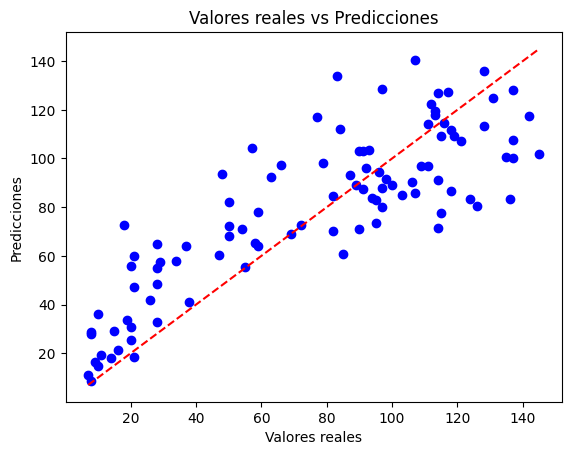

In [87]:
plot_result_evaluate(y_test, preds_test_lr)


La siguiente gráfica muestra una comparación entre los valores reales (Actual) y los valores previstos (Predicted) de la vida útil restante (RUL) de motores en un conjunto de datos de prueba.



<Figure size 640x480 with 0 Axes>

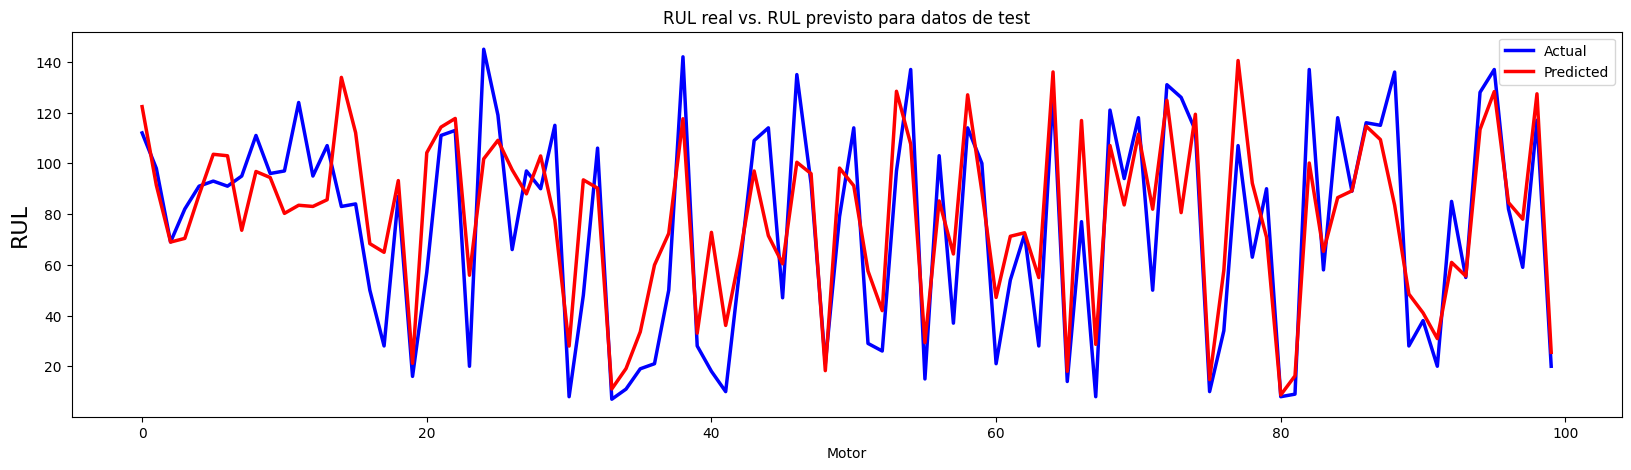

In [88]:
plot_serie_evaluate_result(y_test,preds_test_lr)


El eje X (Motor): Representa los motores individuales o las instancias en el conjunto de prueba. El eje Y (RUL): Representa la vida útil restante, expresada en ciclos. La curva azul (Actual): Muestra los valores reales de RUL obtenidos a partir del conjunto de prueba. La curva roja (Predicted): Muestra los valores de RUL previstos por el modelo de Regresión lineal

### 9.2. Support Vector Machine (SVM)

Para determinar kernels es muy importante escalar el conjunto de datos. En ese caso, para el kernel lineal, no es tan relevante, aunque es posible que proporciones mejores resultados.

In [90]:
# Crear el modelo
svr = SVR(kernel='rbf', gamma=0.05, C=1000)
svr.fit(X_train_scaled, y_train)


SVR(C=1000, gamma=0.05)

In [91]:
# Predecir los resultados
preds_train_svr = svr.predict(X_train_scaled)
preds_test_svr = svr.predict(X_test_scaled)


In [92]:
# evaluar
mae_train_svr, rmse_train_svr, r2_train_svr = evaluate(y_train, preds_train_svr,'train')
mae_test_svr, rmse_test_svr, r2_test_svr = evaluate(y_test, preds_test_svr,'test')

----- train -----
RMSE: 21.18
MAE : 13.94
R2  : 0.74

----- test -----
RMSE: 21.74
MAE : 16.46
R2  : 0.73



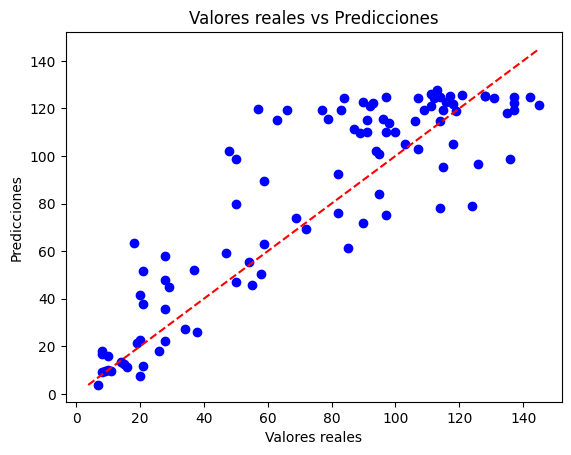

In [93]:
plot_result_evaluate(y_test, preds_test_svr)

<Figure size 640x480 with 0 Axes>

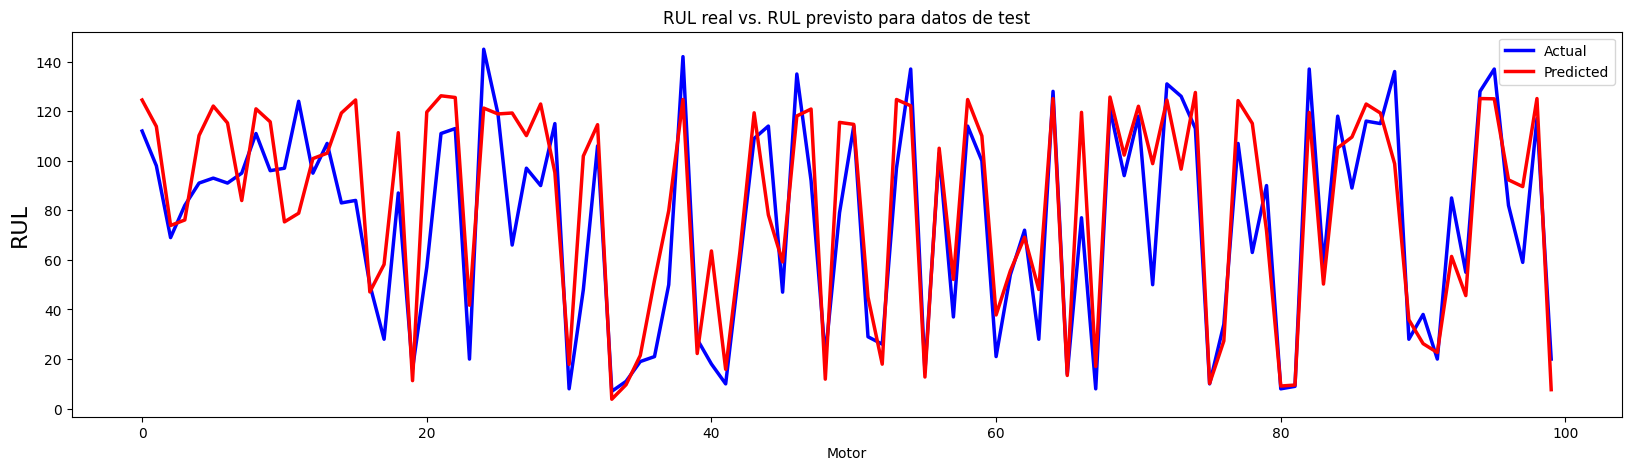

In [94]:
plot_serie_evaluate_result(y_test,preds_test_svr)

In [95]:
# Crea un nuevo DataFrame para añadir
new_results = pd.DataFrame({
    'Model': ['SVR (Ajuste de hiperparámetros)'],
    'MAE train': [mae_train_svr],
    'RMSE train': [rmse_train_svr],
    'R2 train': [r2_train_svr],
    'MAE test': [mae_test_svr],
    'RMSE test': [rmse_test_svr],
    'R2 test': [r2_test_svr]
})

results = pd.concat([results, new_results], ignore_index=True)
results

,Model,MAE train,RMSE train,R2 train,MAE test,RMSE test,R2 test
0,Regresión lineal,18.484758,22.734165,0.702385,18.249019,22.914265,0.695945
1,SVR (Ajuste de hiperparámetros),13.941799,21.182364,0.741628,16.459070,21.737346,0.726376
